### SI 670: Final Project Regression Model

#### Step 0. Import necessary libraries/packages and dataset

In [17]:
# Import libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NFL data library
import nfl_data_py as nfl

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# NFL data 2015-2024
df = nfl.import_pbp_data([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

# Shape of dataframe
print(df.shape)

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
(483605, 398)


In [4]:
# Define our necessary play types
fantasy_play_types = ['pass', 'run', 'qb_kneel']

# Exclusion play types
exclude_play_types = [
    'no_play',  
    'qb_spike',      
    'field_goal',    
    'extra_point',   
    'punt',          
    'kickoff',       
]

# Filter DataFrame to include only fantasy_play_types
df_fantasy_plays = df[
    df['play_type'].isin(fantasy_play_types) & 
    ~df['play_type'].isin(exclude_play_types)
].copy()

print(f"Original plays: {len(df)}")
print(f"Plays retained for skill features: {len(df_fantasy_plays)}")

Original plays: 483605
Plays retained for skill features: 348478


In [5]:
# Ensure QB gets the negative fantasy points for kneeling the football
df_fantasy_plays['rusher_player_id'] = np.where(
    (df_fantasy_plays['play_type'] == 'qb_kneel') & 
    df_fantasy_plays['rusher_player_id'].isnull(), 
    df_fantasy_plays['passer_player_id'], 
    df_fantasy_plays['rusher_player_id']
)

# Exclusion of penalties and two_point attempts
df_mdl1 = df_fantasy_plays[
    (df_fantasy_plays['penalty'] == 0) & 
    (df_fantasy_plays['two_point_attempt'] == 0)
].copy()

# Initial feature set for model
mdl_cols = [
    # Identifiers
    'game_id', 'play_id', 'season', 'week', 'posteam', 'defteam', 
    'passer_player_id', 'rusher_player_id', 'receiver_player_id', 
    
    # Raw metrics needed for target variable calculation
    'passing_yards', 'pass_touchdown', 'interception', 
    'rushing_yards', 'rush_touchdown', 'fumble_lost',
    'receiving_yards', 'complete_pass',
    
    # Efficiency metrics
    'play_type', 'yards_gained', 'epa', 'cpoe'
]

# Filter DataFrame for retained columns
df_mdl0 = df_mdl1[mdl_cols].copy()

#### Step 1. Feature Engineering

1. Define fantasy score rules per play/week and target variable.

In [7]:
# Define Scoring Rules for half point PPR
scoring_rules = {
    'pass_yd': 0.04, 'pass_td': 4, 
    'rush_yd': 0.1, 'rush_td': 6, 
    'rec_yd': 0.1, 'rec_td': 6, 
    'rec': 0.5, # Half-PPR point for each reception
    'int': -2, 'fumble_lost': -2,
    'qb_kneel_yd': -0.1
}

# Calculate fantasy points per play
def calculate_fantasy_points_per_play(df, scoring_rules):
    """Calculates all fantasy points earned on a single play based on half-PPR rules."""
    
    # Passing Points (QB)
    df['fp_pass'] = (df['passing_yards'].fillna(0) * scoring_rules['pass_yd']) + \
                    (df['pass_touchdown'].fillna(0) * scoring_rules['pass_td'])
                                
    # Rushing Points (RB/QB)
    df['fp_rush'] = (df['rushing_yards'].fillna(0) * scoring_rules['rush_yd']) + \
                    (df['rush_touchdown'].fillna(0) * scoring_rules['rush_td'])
                                
    # Reception variable for receivers. No catch metric in dataset
    is_reception = df['complete_pass'].fillna(0) == 1
    
    df['fp_rec'] = np.where(is_reception, 
        (df['receiving_yards'].fillna(0) * scoring_rules['rec_yd']) + \
        (df['pass_touchdown'].fillna(0) * scoring_rules['rec_td']) + \
        (df['complete_pass'].fillna(0) * scoring_rules['rec']),
        0
    )
    
    # Interception (for primary passer)
    df['fp_int'] = df['interception'].fillna(0) * scoring_rules['int']

    # Fumble Lost (for primary ball carrier/or receiver)
    df['fp_fumble_lost'] = df['fumble_lost'].fillna(0) * scoring_rules['fumble_lost']
    df['fp_fumble_penalty'] = df['fp_fumble_lost'].fillna(0)
    
    # QB Kneel adjustment
    df['fp_kneel'] = np.where(df['play_type'] == 'qb_kneel', 
                              df['yards_gained'].fillna(0) * scoring_rules['qb_kneel_yd'], 0)
    
    return df

df_mdl1 = calculate_fantasy_points_per_play(df_mdl0, scoring_rules)


In [8]:
# Calculate weekly fantasy points. Need to aggregate each play for each player
def calculate_weekly_fantasy_points_final(df):
    """Aggregates all fantasy points earned by a player across a week."""
    
    # Calculate the total points for each respective player id
    df['fp_pass_total'] = df['fp_pass'].fillna(0) + df['fp_int'].fillna(0) + df['fp_kneel'].fillna(0)
    df['fp_rush_total'] = df['fp_rush'].fillna(0)
    df['fp_rec_total'] = df['fp_rec'].fillna(0)
    
    id_vars = ['season', 'week']
    
    contributions_map = {
        'passer_player_id': 'fp_pass_total',
        'rusher_player_id': 'fp_rush_total',
        'receiver_player_id': 'fp_rec_total',
        
        # Fumble penalty to each of the three primary roles 
        'passer_player_id_fumble': 'fp_fumble_penalty', 
        'rusher_player_id_fumble': 'fp_fumble_penalty',
        'receiver_player_id_fumble': 'fp_fumble_penalty',
    }

    contributions = []
    for id_col_raw, point_col in contributions_map.items():
        id_col = id_col_raw.replace('_fumble', '')
        
        temp_df = df.rename(columns={id_col: 'player_id', point_col: 'points'})
        contributions.append(temp_df[id_vars + ['player_id', 'points']])

    # Stack contributions and drop any missing player ids
    df_all_points = pd.concat(contributions, ignore_index=True)
    df_all_points.dropna(subset=['player_id'], inplace=True)
    
    # Group by week and season for each respective player id and return the table
    df_target_Y = df_all_points.groupby(id_vars + ['player_id'])['points'].sum().reset_index()
    
    return df_target_Y.rename(columns={'points': 'Y_target_points'})

df_target_Y = calculate_weekly_fantasy_points_final(df_mdl1)

##### 2. Aggregation and creation of positions (position does not exist in dataset)

In [9]:
# Define aggregation rules: sum for volume stats, mean for efficiency stats
feature_agg_rules = {
    'passing_yards': 'sum',
    'rushing_yards': 'sum',
    'receiving_yards': 'sum',
    'pass_touchdown': 'sum',
    'rush_touchdown': 'sum',
    'interception': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean',
    'cpoe': 'mean',
}

id_vars = ['season', 'week'] 
feature_cols = list(feature_agg_rules.keys())
context_cols = ['posteam', 'defteam']

# Select all necessary columns from df_mdl1
df_select = df_mdl1[id_vars + feature_cols + context_cols + 
    ['passer_player_id', 'rusher_player_id', 'receiver_player_id']].copy()

# Reshape data to get one row per player role per play
df_X_long = pd.melt(
    df_select,
    id_vars=id_vars + feature_cols + context_cols, 
    value_vars=['passer_player_id', 'rusher_player_id', 'receiver_player_id'],
    var_name='role_type',
    value_name='player_id'
)
df_X_long.dropna(subset=['player_id'], inplace=True)

# Aggregation of feature matrix
group_keys = ['season', 'week', 'player_id', 'posteam', 'defteam']

df_features_X = df_X_long.groupby(group_keys).agg(feature_agg_rules).reset_index()

# Create total plays involved metric
df_counts = df_X_long.groupby(group_keys).size().reset_index(name='total_plays_involved')
df_features_X = pd.merge(df_features_X, df_counts, on=group_keys, how='left')
print(df_features_X.head())


# Count play types by player for position inference
role_counts = (
    df_X_long
    .groupby(['player_id', 'role_type'])
    .size()
    .reset_index(name='count')
)

player_role_summary = (
    role_counts
    .pivot(index='player_id', columns='role_type', values='count')
    .fillna(0)
)

# Logic to infer what position a player most likely is based on tendencies
def infer_position(row):
    pass_count = row.get('passer_player_id', 0)
    rush_count = row.get('rusher_player_id', 0)
    rec_count  = row.get('receiver_player_id', 0)

    if pass_count >= 50:
        return 'QB'
    if rush_count >= 10 and rush_count > rec_count * 2:
        return 'RB'
    if rec_count >= 10:
        return 'WR/TE'
    return 'OTH'

player_role_summary['position'] = player_role_summary.apply(infer_position, axis=1)
player_position_map = player_role_summary['position']

   season  week   player_id posteam defteam  passing_yards  rushing_yards  \
0    2015     1  00-0010346     DEN     BAL          175.0           -1.0   
1    2015     1  00-0019596      NE     PIT          275.0            1.0   
2    2015     1  00-0020337     BAL     DEN           13.0            0.0   
3    2015     1  00-0020531      NO     ARI          355.0            3.0   
4    2015     1  00-0021206     CLE     NYJ           49.0           10.0   

   receiving_yards  pass_touchdown  rush_touchdown  interception  \
0            175.0             0.0             0.0           1.0   
1            275.0             4.0             0.0           0.0   
2             13.0             0.0             0.0           1.0   
3            355.0             1.0             0.0           1.0   
4             49.0             0.0             0.0           0.0   

   complete_pass       epa       cpoe  total_plays_involved  
0           24.0 -0.267725  -7.397210                    45  
1   

##### 3. Merging of features and target variable. Creation of features (lagged, volatility and opponent)

In [12]:
# Merge features with the target variable
df_final = pd.merge(
    df_features_X, 
    df_target_Y,    
    on=['season', 'week', 'player_id'],
    how='left'
)
df_final['Y_target_points'] = df_final['Y_target_points'].fillna(0)
df_final.sort_values(by=['player_id', 'season', 'week'], inplace=True)

# Add player workload metric
team_opportunities = df_final.groupby(['season', 'week', 'posteam'])['total_plays_involved'].sum().rename('team_total_plays').reset_index()
df_final = df_final.merge(team_opportunities, on=['season', 'week', 'posteam'], how='left')
df_final['play_share'] = df_final['total_plays_involved'] / df_final['team_total_plays']

###############################
# Creation of lagged features #
###############################

# Prior week values
df_final['Y_lag_1'] = df_final.groupby('player_id')['Y_target_points'].shift(1)
df_final['Y_roll_avg_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
)

# Cumulative career average
df_final['Y_cum_avg'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).mean()
)

###################################
# Creation of volatility features #
###################################

# 3 week rolling standard deviation
df_final['Y_roll_std_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
)

# 3 week rolling absolute error in target points
df_final['Y_MAE_roll_3'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).apply(lambda y: np.mean(np.abs(y - np.mean(y))), raw=True)
)

# Cumulative career standard deviation
df_final['Y_cum_std'] = df_final.groupby('player_id')['Y_target_points'].transform(
    lambda x: x.shift(1).expanding(min_periods=1).std() 
)

# 3 week rolling average of the amount plays player is a part of
df_final['play_share_roll_std_3'] = df_final.groupby('player_id')['play_share'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
)

# Deviation from Cumulative Average 
df_final['Y_dev_from_cum_avg'] = df_final['Y_roll_avg_3'] - df_final['Y_cum_avg']

###################################
# Creation of oppponent features #
###################################

# Use the filtered play-by-play data (df_mdl1) to calculate defensive rolling stats
df_defense_metrics = df_mdl1[['season', 'week', 'defteam', 'epa']].copy()
df_defense_metrics.rename(columns={'defteam': 'defense_team_id'}, inplace=True)


df_defense_agg = df_defense_metrics.groupby(['season', 'week', 'defense_team_id']).agg(
    epa_allowed_game=('epa', 'mean')
).reset_index()

# Calculate Rolling stats for defense
df_defense_agg.sort_values(by=['defense_team_id', 'season', 'week'], inplace=True)

df_defense_agg['Opp_EPA_Mean'] = df_defense_agg.groupby('defense_team_id')['epa_allowed_game'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Merge defensive stats
df_def_stats_merge = df_defense_agg[['season', 'week', 'defense_team_id', 'Opp_EPA_Mean']].copy()



# Merge Defensive Stats with existing dataframe
df_final = pd.merge(
    df_final,
    df_def_stats_merge,
    left_on=['season', 'week', 'defteam'], 
    right_on=['season', 'week', 'defense_team_id'],
    how='left'
)

# Calculate team pass attempts per week
team_pass_attempts = df_mdl1[df_mdl1['play_type'] == 'pass'].copy()
team_pass_attempts = team_pass_attempts.groupby(['season', 'week', 'posteam']).size().reset_index(name='Team_Pass_Attempts')

#  Merge into df_final
df_final = pd.merge(df_final, team_pass_attempts, on=['season', 'week', 'posteam'], how='left')

# Fill any null values with zero
df_final['Team_Pass_Attempts'] = df_final['Team_Pass_Attempts'].fillna(0)

# Calculate target share variable for receivers and running backs
df_final['Target_Share'] = np.where(
    df_final['Team_Pass_Attempts'] > 0, 
    df_final['complete_pass'] / df_final['Team_Pass_Attempts'], 
    0
)

# Prior week target share
df_final['Target_Share_lag_1'] = df_final.groupby('player_id')['Target_Share'].shift(1)

# Define the threshold for a "Spike" game where player scores over 20 points which is a very high point total
spike_threshold = 20.0

# Create a binary column if player experience a spike game
df_final['is_spike'] = (df_final['Y_target_points'] >= spike_threshold).astype(int)

# 5 week rolling average of spike variable
df_final['Y_Spike_Rate_5'] = df_final.groupby('player_id')['is_spike'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# Drop columns not needed for model fitting
df_final.drop(columns=['defense_team_id', 'team_total_plays', 'Team_Pass_Attempts', 'Target_Share'], inplace=True)

# Fill nulls for the first few weeks of data
new_features_to_fill = [col for col in df_final.columns if col not in group_keys + ['Y_target_points']]
df_final[new_features_to_fill] = df_final[new_features_to_fill].fillna(0)

#### Step 2. Quantile Regression Training and Evaluation


Training Quantile Models (Non-Leaking Features)
Training quantile 0.1
Training quantile 0.5
Training quantile 0.9
Evaluation Summary
MAE (Median Prediction): 2.47
80% PI Coverage Actual: 76.89%
Pinball Loss (10th Quantile): 0.4358


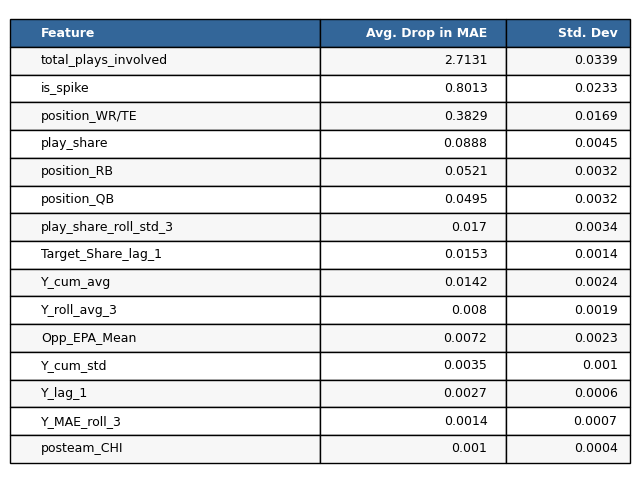

In [13]:

id_cols = ['season', 'week', 'player_id']
target_col = 'Y_target_points'


# Features that will cause data leakage and need to be dropped
leakage_features = [
    'passing_yards', 'rushing_yards', 'receiving_yards', 'pass_touchdown', 
    'rush_touchdown', 'interception', 'complete_pass', 
    'epa', 'cpoe'
]

# Create final set of features, remove target column and leakage features
df_features = df_final.drop(columns=[target_col] + leakage_features)

# Insert position feature
df_features['position'] = df_features['player_id'].map(player_position_map)
df_features['position'] = df_features['position'].fillna('OTH')

# The final list of ID columns that must be removed from the feature matrix X
drop_cols = ['season', 'week', 'player_id']

# Create the final feature matrix X by dropping all ID columns
X = df_features.drop(columns=drop_cols)

# Define the features that require encoding
categorical_features = ['posteam', 'defteam', 'position'] 

# Define numerical features (everything else after IDs are dropped)
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define target
y = df_final[target_col]


# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' 
)

# Chronological train/test split
split_point = int(len(X) * 0.90)

X_train = X.iloc[:split_point]
X_test  = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test  = y.iloc[split_point:]
ids_test = df_final[id_cols].iloc[split_point:]

# Transform data before fitting
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
X_train_scaled = X_train_scaled
X_test_scaled = X_test_scaled


# Train quantile models
quantiles = [0.10, 0.50, 0.90]
y_preds = {}
models = {} 

print("\nTraining Quantile Models")
for q in quantiles:
    print(f"Training quantile {q}")
    # Using increased hyperparameters for better risk sensitivity: max_depth=8, learning_rate=0.075, max_iter=1000
    model = HistGradientBoostingRegressor(
        loss='quantile',
        quantile=q,
        max_depth=8,        
        learning_rate=0.01, 
        max_iter=2000,      
        random_state=321
    )
    model.fit(X_train_scaled, y_train)
    y_preds[q] = model.predict(X_test_scaled)
    models[q] = model


################################################################
# Evaluation of quantile models and feature importance
################################################################

# Build df_predictions for evaluation
def pinball_loss(y_true, y_pred, q):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, q * err, (1 - q) * -err))
    
df_predictions = pd.DataFrame({
    'y_test' : y_test.values,
    'pred_10': y_preds[0.10],
    'pred_50': y_preds[0.50],
    'pred_90': y_preds[0.90]
}, index=y_test.index)
df_predictions = df_predictions.join(ids_test)
df_predictions['position'] = df_predictions['player_id'].map(player_position_map)
df_predictions['position'] = df_predictions['position'].fillna('OTH')

# Evaluation Metrics Summary
mae = mean_absolute_error(df_predictions['y_test'], df_predictions['pred_50'])
coverage = ((df_predictions['y_test'] >= df_predictions['pred_10']) & (df_predictions['y_test'] <= df_predictions['pred_90'])).mean() * 100
pb10 = pinball_loss(df_predictions['y_test'], df_predictions['pred_10'], 0.10)

print("Evaluation Summary")
print(f"MAE (Median Prediction): {mae:.2f}")
print(f"80% PI Coverage Actual: {coverage:.2f}%")
print(f"Pinball Loss (10th Quantile): {pb10:.4f}")

# Final list of features for feature importance
feature_names = list(preprocessor.transformers_[0][1].get_feature_names_out(categorical_features))
feature_names.extend(numerical_features)


# Calculate Permutation Feature Importance (PFI

# Use the median model and MAE as the scoring metric.
pfi_results = permutation_importance(
    models[0.50],
    X_test_scaled,
    y_test,
    scoring='neg_mean_absolute_error',
    n_repeats=10,
    random_state=42,
    n_jobs=-1 
)

# Create feature importance dataframe
df_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': pfi_results.importances_mean,
    'Importance_Std': pfi_results.importances_std
})

# Sort by the mean importance (largest drop in MAE)
df_feature_importance = df_feature_importance.sort_values(by='Importance_Mean', ascending=False)


# Create PNG Table for PFI

# Select Top 15 features for visual
df_plot_pfi = df_feature_importance.head(15).copy()

df_plot_pfi['Importance_Mean'] = df_plot_pfi['Importance_Mean'].round(4)
df_plot_pfi['Importance_Std'] = df_plot_pfi['Importance_Std'].round(4)

# Define custom column headers to ensure they fit
custom_col_labels = ['Feature', 'Avg. Drop in MAE', 'Std. Dev']

fig, ax = plt.subplots(figsize=(8, 6)) 

ax.axis('off')
ax.axis('tight')

# Adjust column widths: Feature takes largest space, Std. Dev is smallest
col_widths = [0.50, 0.30, 0.20] 

# Create table with adjusted widths and custom labels
table = ax.table(
    cellText=df_plot_pfi.values,
    colLabels=custom_col_labels, # Use shorter labels
    colWidths=col_widths, 
    cellLoc='center',
    loc='center'
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(9)

for (row, col), cell in table.get_celld().items():
    cell.set_height(0.06)
    if row == 0:
        cell.set_facecolor("#336699")
        cell.set_text_props(color='white', weight='bold')
    elif row % 2 != 0: 
        cell.set_facecolor('#f7f7f7')
    
    # Align Feature name left, Importance right
    if col == 0:
        cell.set_text_props(ha='left', va='center')
    else:
        cell.set_text_props(ha='right', va='center')


output_filename_pfi = 'feature_importance_table.png'
plt.savefig(output_filename_pfi, bbox_inches='tight', dpi=300)

#### Step 3. Benchmark Model Comparison and Evaluation of Quantile Regressions

In [14]:
# Comparison of HGBR model to benchmark models

benchmark_models = {}
benchmark_results = {}

# Ridge Regression Benchmark (Similar to Linear Regression, but with L1 regularization)
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)
benchmark_models['Ridge Regression'] = ridge
benchmark_results['Ridge Regression'] = {
    'Test MAE': mean_absolute_error(y_test, ridge_preds),
    'Test MSE': mean_squared_error(y_test, ridge_preds),
    'Test R2': r2_score(y_test, ridge_preds)
}

# Decision Tree Regression Benchmark (Simple non-linear tree base)
dtr = DecisionTreeRegressor(max_depth=8, random_state=42)
dtr.fit(X_train_scaled, y_train)
dtr_preds = dtr.predict(X_test_scaled)
benchmark_models['Decision Tree Regression'] = dtr
benchmark_results['Decision Tree Regression'] = {
    'Test MAE': mean_absolute_error(y_test, dtr_preds),
    'Test MSE': mean_squared_error(y_test, dtr_preds),
    'Test R2': r2_score(y_test, dtr_preds)
}

| Model                    |   Test MAE |   Test MSE |   Test R2 | PICP   |
|:-------------------------|-----------:|-----------:|----------:|:-------|
| Quantile HGBR (Median)   |     2.4729 |    13.0665 |    0.6985 | 76.89% |
| Decision Tree Regression |     2.5751 |    12.6635 |    0.7078 | N/A    |
| Ridge Regression         |     2.9377 |    15.0254 |    0.6533 | N/A    |
Successfully saved table as evaluation_benchmarking_table_wider.png


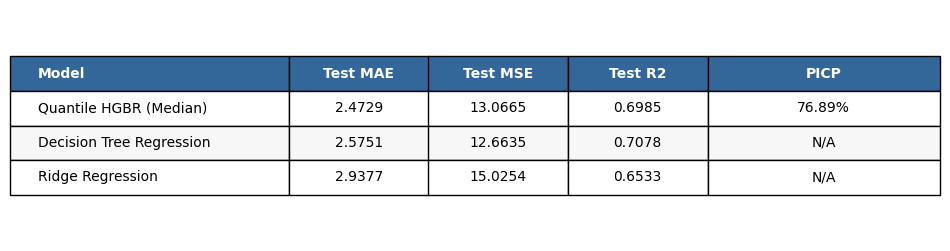

In [15]:
# Train benchmark models

# Ridge Regression Benchmark (Robust Linear Baseline)
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)

# Decision Tree Regression Benchmark (Simple Non-Linear Baseline)
dtr = DecisionTreeRegressor(max_depth=8, random_state=42)
dtr.fit(X_train_scaled, y_train)
dtr_preds = dtr.predict(X_test_scaled)

# Compile metric results 
def get_metrics(y_true, y_pred, model_name):
    """Helper function to calculate standard performance metrics."""
    return {
        'Model': model_name,
        'Test MAE': mean_absolute_error(y_true, y_pred),
        'Test MSE': mean_squared_error(y_true, y_pred),
        'Test R2': r2_score(y_true, y_pred)
    }

# Compile all model metrics
ridge_results = get_metrics(y_test, ridge_preds, 'Ridge Regression')
dtr_results = get_metrics(y_test, dtr_preds, 'Decision Tree Regression')

# HGBR resuluts
hgb_q50_preds = models[0.50].predict(X_test_scaled)
hgb_results = get_metrics(y_test, hgb_q50_preds, 'Quantile HGBR (Median)')

# Combine into a final DataFrame
final_results_list = [hgb_results, dtr_results, ridge_results]
df_results = pd.DataFrame(final_results_list)

# Add the PICP metric for the Quantile model
df_results['PICP'] = np.where(df_results['Model'] == 'Quantile HGBR (Median)', f"{coverage:.2f}%", 'N/A')
print(df_results.set_index('Model').to_markdown(floatfmt=".4f"))

for col in ['Test MAE', 'Test MSE', 'Test R2']:
    # Format to 4 decimal places for consistency
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce').round(4).fillna(df_results[col])

# Define the columns in the desired order for the table layout
df_plot = df_results[['Model', 'Test MAE', 'Test MSE', 'Test R2', 'PICP']]

fig, ax = plt.subplots(figsize=(12, 3)) 

# Hide axes borders and ticks
ax.axis('off')
ax.axis('tight')


col_widths = [0.30, 0.15, 0.15, 0.15, 0.25] 

# Create the table object
table = ax.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns,
    colWidths=col_widths, # <--- ADDED THIS LINE
    cellLoc='center',
    loc='center'
)

# Style the table for visual appeal
table.auto_set_font_size(False)
table.set_fontsize(10)

# Apply bold white font to header and alternate row colors
for (row, col), cell in table.get_celld().items():
    cell.set_height(0.15)
    if row == 0:
        cell.set_facecolor("#336699")
        cell.set_text_props(color='white', weight='bold')
    elif row % 2 == 0:
        cell.set_facecolor('#f7f7f7')
    
    # Left align the text in the Model column for better readability
    if col == 0:
        cell.set_text_props(ha='left', va='center')
    else:
        cell.set_text_props(ha='center', va='center')


# Save the figure as a PNG file
output_filename = 'evaluation_benchmarking_table_wider.png'
plt.savefig(output_filename, bbox_inches='tight', dpi=300)

print(f"Successfully saved table as {output_filename}")

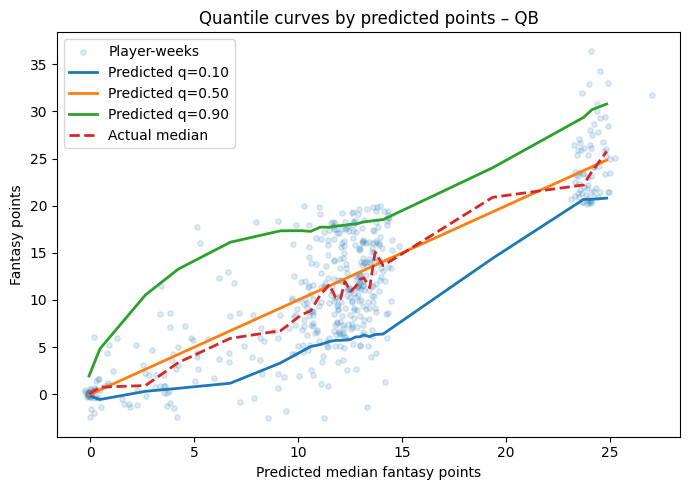

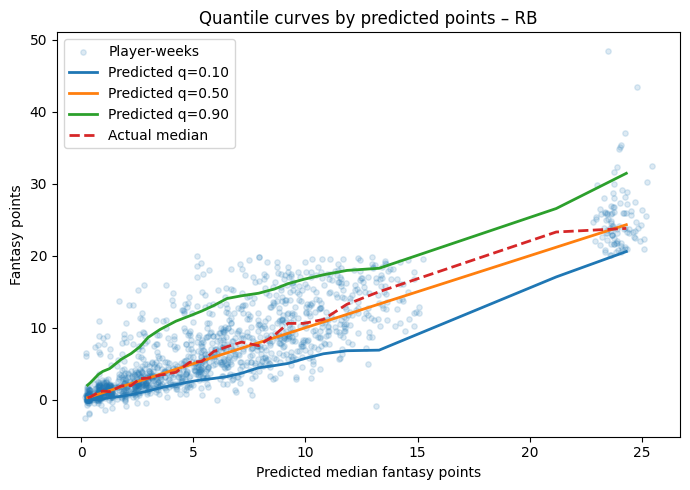

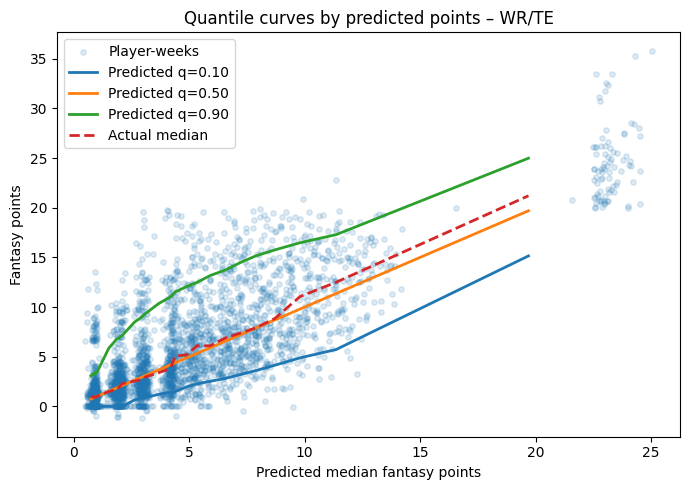

In [18]:
def plot_quantile_curves_by_position(df_predictions, position, n_bins=25):
    """
    Make a quantile fan plot for a single position, similar to the demo image:
      - x-axis: predicted median points (pred_50)
      - lines: avg predicted 10/50/90 quantiles
      - line: actual median in each bin (ground truth)
      - background: scatter of individual weeks
    """
    # Filter to this position
    df_pos = df_predictions[df_predictions['position'] == position].copy()
    if df_pos.empty:
        print(f"No rows found for position {position}")
        return

    # Sort by predicted median
    df_pos = df_pos.sort_values('pred_50')

    # Make quantile bins on pred_50
    nbins = min(n_bins, max(5, len(df_pos) // 20))
    df_pos['pred_bin'] = pd.qcut(df_pos['pred_50'], q=nbins, duplicates='drop')

    grouped = df_pos.groupby('pred_bin')

    # x = mean pred_50 in each bin
    x = grouped['pred_50'].mean()

    # predicted quantiles (averaged within bins)
    pred_q10 = grouped['pred_10'].mean()
    pred_q50 = grouped['pred_50'].mean()
    pred_q90 = grouped['pred_90'].mean()

    # "ground truth" curve: median actual in each bin
    actual_med = grouped['y_test'].median()

    # Plot data
    fig, ax = plt.subplots(figsize=(7, 5))

    # Scatter points for held out data
    ax.scatter(df_pos['pred_50'], df_pos['y_test'],
               alpha=0.15, s=15, label='Player-weeks')

    # Quantile curves
    ax.plot(x, pred_q10, linewidth=2, label='Predicted q=0.10')
    ax.plot(x, pred_q50, linewidth=2, label='Predicted q=0.50')
    ax.plot(x, pred_q90, linewidth=2, label='Predicted q=0.90')

    # Actual median
    ax.plot(x, actual_med, linewidth=2, linestyle='--', label='Actual median')

    ax.set_xlabel('Predicted median fantasy points')
    ax.set_ylabel('Fantasy points')
    ax.set_title(f'Quantile curves by predicted points – {position}')
    ax.legend()
    plt.tight_layout()
    plt.show()




# Example: just QBs
plot_quantile_curves_by_position(df_predictions, position='QB')
plot_quantile_curves_by_position(df_predictions, position='RB')
plot_quantile_curves_by_position(df_predictions, position='WR/TE')